In [1]:
import optuna
from optuna.importance import get_param_importances
import pickle
import torch
import os
import copy
os.chdir('/home/bjartur/workspace/python_focalh_clustering/') # Laptop and Desktop
from importlib import reload

import sys
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import yaml
import pandas as pd
from matplotlib.ticker import MultipleLocator
from scipy.optimize import linear_sum_assignment
from lib.misc_util import open_bundle


# Add the root folder to Python path
root_folder = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_folder not in sys.path:
    sys.path.append(root_folder)

import lib.unet_nn as UNet
import lib.modified_aggregation as MA
import lib
from lib.modified_aggregation_clusterer import ModifiedAggregationClusterer
from lib.unet_clusterer import UNetClusterer
import lib.sklearn_clusterer as sklcl
from lib.focal import FocalH
from lib.base_nn import Data
from lib import metrics# import count_clusters, count_labels, compute_score, total, separation_efficiency



# Explore resolved and separation function

In [81]:
from importlib import reload
reload(lib)

filename = "/home/bjartur/workspace/python_focalh_clustering/data/eval/EVAL_E350_P5_N100.root"
tfile = ROOT.TFile(filename, "READ")
ttree = tfile.Get("EventsTree")
event = 61
ttree.GetEntry(event)

#reload(lib.modified_aggregation_clusterer)


cnn_study = open_bundle("studies/best/cnn/"+"study_cnn_train_tiny_sep_100.pkl")
clus = UNetClusterer()
d = clus.cluster_debug(filename, ttree, event, cnn_study, cnn_study["study"].best_params)

kmeans_study = open_bundle("studies/best/kmeans/"+"study_kmeans_train_tiny_sep_100.pkl")
clus = sklcl.SklearnClusterer()
d = clus.cluster_debug(filename, ttree, event, kmeans_study["method"], kmeans_study["study"].best_params)

ma_study = open_bundle("studies/best/ma/"+"study_ma_train_tiny_sep_100.pkl")
clus = ModifiedAggregationClusterer()
d = clus.cluster_debug(filename, ttree, event, ma_study["method"], ma_study["study"].best_params)


for key,item in d.items():
    print(key)

x
y
values
energy
coms
labels
tags


In [82]:
from importlib import reload
reload(metrics)

di = dict()
di["tags"] = [d["tags"]]
di["labels"] = [d["labels"]]
di["values"] = [d["values"]]
di["energy"] = [d["energy"]]
di["x"] = [d["x"]]
di["y"] = [d["y"]]

#metrics.separation_efficiency([d["tags"]], [d["labels"]], [d["values"]], [d["energy"]])
matched = metrics.separation_efficiency(di)
for key,item in matched.items():
    print(key)

tags
labels
values
energy
x
y
separation_efficiency
energy_pairs
tag_coms
label_coms
matched_indices


In [83]:
matched["energy_pairs"]

[[(np.float32(273.56308), np.float32(212.21144)),
  (np.float32(201.7531), np.float32(179.16026)),
  (np.float32(241.39847), np.float32(133.4995)),
  (np.float32(108.36735), np.float32(53.01439)),
  (np.float32(155.35965), np.float32(359.44128)),
  (0, np.float32(-0.8263633)),
  (0, np.float32(-14.991636))]]

In [84]:
matched["separation_efficiency"]

array([[1., 7.]])

In [85]:
matched["matched_indices"]

[[(2, 3), (4, 4), (1, 2), (0, 1), (3, 0), (-1, 5), (-1, 6)]]

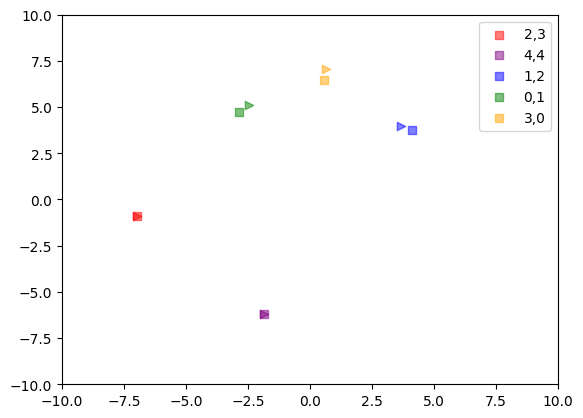

In [86]:
colors = ["green", "blue", "red", "orange", "purple", "yellow", "pink"]
for p,c in matched["matched_indices"][0]:
    if p==-1 or c==-1:
        continue
    plt.scatter(matched["tag_coms"][0][c][0], matched["tag_coms"][0][c][1], color=colors[p], alpha=0.5, marker="s", label=f"{p},{c}")
    plt.scatter(matched["label_coms"][0][p][0], matched["label_coms"][0][p][1], color=colors[p], alpha=0.5, marker=">")
    plt.xlim(-10,10)
    plt.ylim(-10,10)
    plt.legend()
#for i in range(5):
#    plt.scatter(matched[2][0][i][0], matched[2][0][i][1], color=colors[i], marker="s")
#    plt.scatter(matched[3][0][i][0], matched[3][0][i][1], color=colors[i], marker=">")

ValueError: zero-size array to reduction operation maximum which has no identity

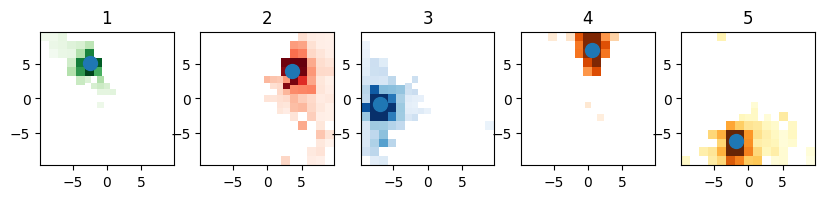

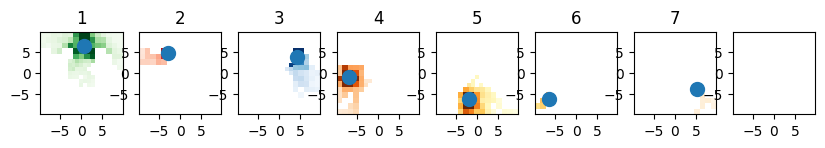

In [87]:
def com(x,y,v):
    mask = v > v.max()*0.75
    xcom = (x[mask]*v[mask]).sum()/v[mask].sum()
    ycom = (y[mask]*v[mask]).sum()/v[mask].sum()
    return xcom,ycom

Npart = len(set(d["labels"]))
fig,ax = plt.subplots(ncols=Npart, figsize=(10,4))
foc = FocalH()
iadj = np.load("p2_sim_adj_map2.npy")
for i in range(Npart):
    mask = d["labels"] == i+1
    mask_cl = d["tags"] == i+1
    unmask = d["labels"] != i+1
    unmask_cl = d["tags"] != i+1

    #ax[i].scatter(d["x"][mask], d["y"][mask], marker=".")
    vals = copy.deepcopy(d["values"])
    labels = copy.deepcopy(d["labels"])
    tags = copy.deepcopy(d["tags"])
#    vals[mask] = 0
    labels[unmask] = 0
    tags[unmask_cl] = 0
    foc.heatmap(vals[iadj], labels[iadj], ax[i])
#    foc.heatmap(vals, labels[iadj], ax[i]) # sklearn
    xcom,ycom = com(d["x"][mask], d["y"][mask], d["values"][mask])
    ax[i].scatter(xcom, ycom, marker="o", s=100)
    print()
    #ax[i].scatter(xcom, ycom, marker="o", s=100)
    ax[i].set_title(f"{i+1}")

Ntag = len(set(d["tags"]))
fig,ax = plt.subplots(ncols=Ntag, figsize=(10,4))
for i in range(Ntag):
    mask = d["labels"] == i+1
    mask_cl = d["tags"] == i+1
    unmask = d["labels"] != i+1
    unmask_cl = d["tags"] != i+1

    #ax[i].scatter(d["x"][mask], d["y"][mask], marker=".")
    vals = copy.deepcopy(d["values"])
    labels = copy.deepcopy(d["labels"])
    tags = copy.deepcopy(d["tags"])
#    vals[mask] = 0
    labels[unmask] = 0
    tags[unmask_cl] = 0
    foc.heatmap(vals[iadj], tags[iadj], ax[i])
    xcom,ycom = com(d["x"][mask_cl], d["y"][mask_cl], d["values"][mask_cl])
    ax[i].scatter(xcom, ycom, marker="o", s=100)
    ax[i].set_title(f"{i+1}")

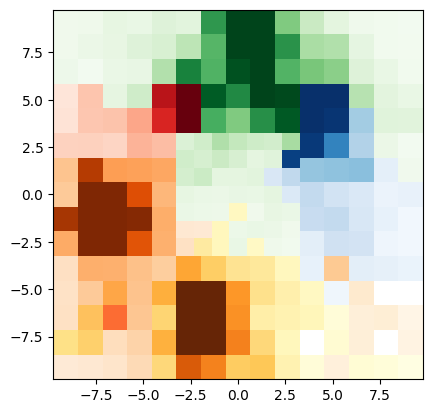

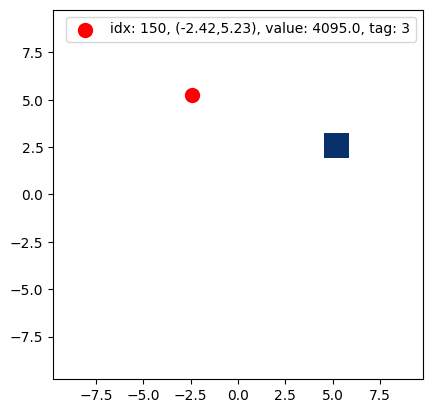

In [27]:


#idx = d["values"].argmax()
plt.show()
idx = 150
vals = copy.deepcopy(d["values"])
tags = copy.deepcopy(d["tags"])
labels = copy.deepcopy(d["labels"])
mask = np.ones(249).astype(bool)
mask[idx]=False
foc.heatmap(vals[iadj], tags)
tags[mask] = 0
foc.heatmap(vals, tags)
plt.scatter(d["x"][idx] , d["y"][idx] , marker="o", s=100, color="red", label=f"idx: {idx}, ({d["x"][idx]:.2f},{d["y"][idx]:.2f}), value: {d["values"][idx]}, tag: {d["tags"][idx]}")
plt.legend()


In [ ]:
with open(v["file"], "rb") as f:
    loaded_bundle = pickle.load(f)
v["data"] = loaded_bundle